In [12]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tikzplotlib

import json
from datetime import datetime

In [87]:
projects_df = pd.read_csv('/root/data/projects.csv',
                         parse_dates=['project_created_at', 'project_last_pushed_at', 'project_updated_at'])
grep_df = pd.read_csv('/root/data/lexical/grep_findings_0_499.csv')
package_df = pd.read_csv('/root/data/packages_0_499.csv')
vet_df = pd.read_csv('/root/data/lexical/vet_findings_0_499.csv')
gosec_df = pd.read_csv('/root/data/lexical/gosec_findings_0_499.csv')
ast_df = pd.read_csv('/root/data/ast/ast_findings_0_499.csv')
function_df = pd.read_csv('/root/data/ast/functions_0_499.csv')
statement_df = pd.read_csv('/root/data/ast/statements_0_499.csv')

# Section 6.5.1 Usage statistics in projects, modules, packages, and registries

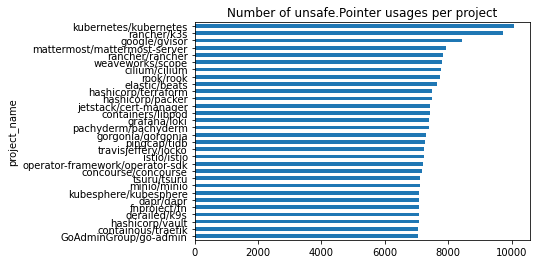

In [32]:
grep_df\
    .groupby('project_name')['project_name'].count()\
    .sort_values(ascending=True)[-30:]\
    .plot.barh(title='Number of unsafe.Pointer usages per project')

tikzplotlib.save('/root/data/figures/stats/unsafe-usages-by-project-n30.tikz')

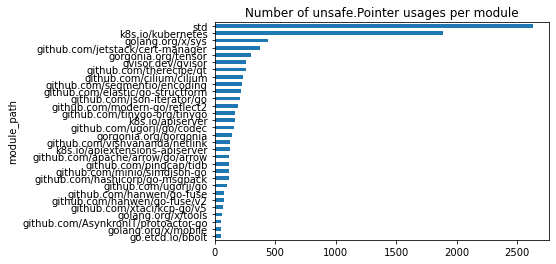

In [39]:
grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .groupby(['module_path', 'project_name'])['module_path'].count()\
    .groupby('module_path').max()\
    .sort_values(ascending=True)[-30:]\
    .plot.barh(title='Number of unsafe.Pointer usages per module')

tikzplotlib.save('/root/data/figures/stats/unsafe-usages-by-module-n30.tikz')

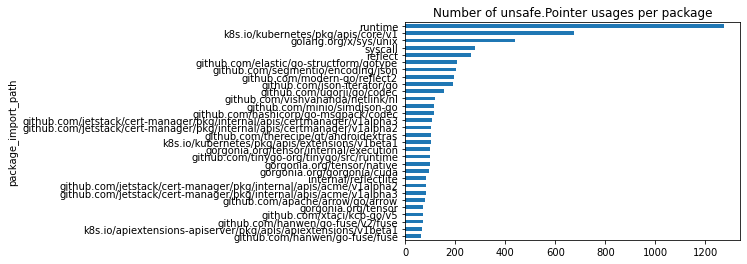

In [33]:
grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .groupby(['package_import_path', 'project_name'])['package_import_path'].count()\
    .groupby('package_import_path').max()\
    .sort_values(ascending=True)[-30:]\
    .plot.barh(title='Number of unsafe.Pointer usages per package')

tikzplotlib.save('/root/data/figures/stats/unsafe-usages-by-package-n30.tikz')

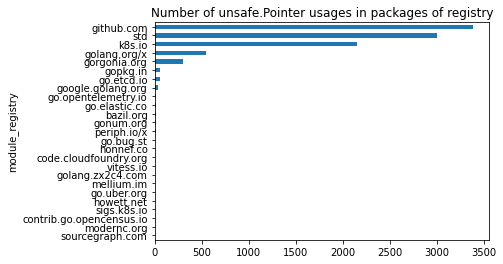

In [31]:
df1 = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .dropna()

df2 = package_df

mdf = pd.merge(df1, df2, how='left', 
         left_on=['project_name', 'package_import_path', 'module_path', 'module_version'], 
         right_on=['project_name', 'import_path', 'module_path', 'module_version'])

mdf\
    .groupby(['module_registry', 'package_import_path', 'project_name'])['module_registry'].count()\
    .groupby(['module_registry', 'package_import_path']).max()\
    .groupby('module_registry').sum()\
    .sort_values(ascending=True)\
    .plot.barh(title='Number of unsafe.Pointer usages in packages of registry')

tikzplotlib.save('/root/data/figures/stats/unsafe-usages-by-registry.tikz')

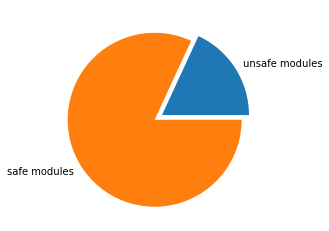

In [70]:
total_modules_count = package_df['module_path'].nunique()
unsafe_modules_count = grep_df['module_path'].nunique()

data = [unsafe_modules_count, total_modules_count - unsafe_modules_count]

plt.pie(data, labels=['unsafe modules', 'safe modules'], explode=(0, 0.1))

tikzplotlib.save('/root/data/figures/stats/pie-modules.tikz')

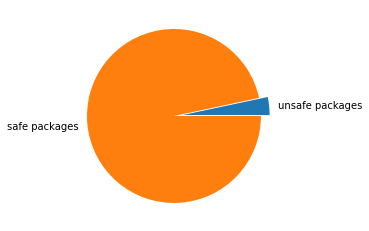

In [71]:
total_packages_count = package_df['import_path'].nunique()
unsafe_packages_count = grep_df['package_import_path'].nunique()

data = [unsafe_packages_count, total_packages_count - unsafe_packages_count]

plt.pie(data, labels=['unsafe packages', 'safe packages'], explode=(0, 0.1))

tikzplotlib.save('/root/data/figures/stats/pie-packages.tikz')

# Section 6.5.2 Distribution of different unsafe token types

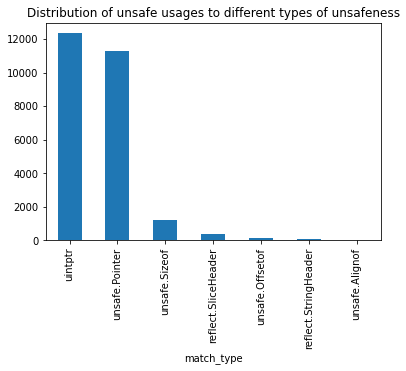

In [50]:
grep_df\
    .groupby(['match_type', 'package_import_path', 'project_name'])['match_type'].count()\
    .groupby(['match_type', 'package_import_path']).max()\
    .groupby('match_type').sum()\
    .sort_values(ascending=False)\
    .plot.bar(title='Distribution of unsafe usages to different types of unsafeness')

tikzplotlib.save('/root/data/figures/tokens-distribution/distribution-different-unsafe-token-types.tikz')

# Section 6.5.3 Module and package popularity

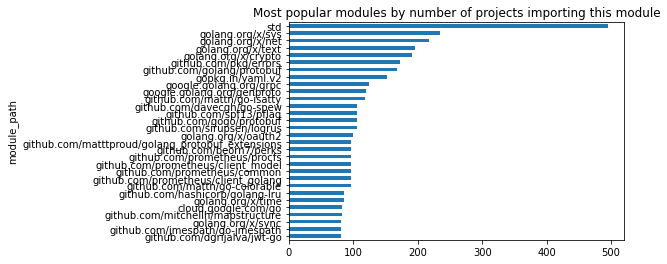

In [43]:
package_df\
    .groupby(['module_path'])['project_name'].nunique()\
    .sort_values(ascending=True)[-30:]\
    .plot.barh(title='Most popular modules by number of projects importing this module')

tikzplotlib.save('/root/data/figures/popularity/popularity-module-n30.tikz')

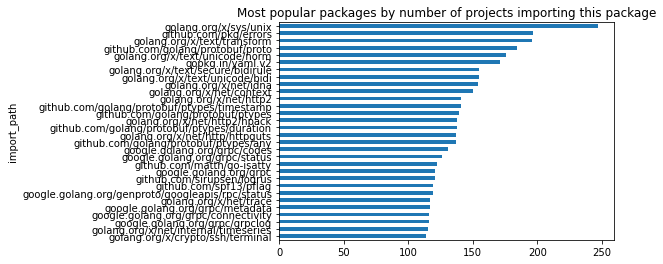

In [49]:
package_df\
    .where(package_df['is_standard']==False)\
    .groupby(['import_path'])['project_name'].nunique()\
    .sort_values(ascending=True)[-30:]\
    .plot.barh(title='Most popular packages by number of projects importing this package')

tikzplotlib.save('/root/data/figures/popularity/popularity-package-without-std-n30.tikz')

# Section 6.5.4 Fluctuation of unsafe usages count over time

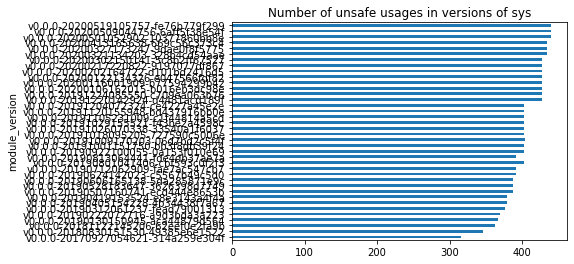

In [42]:
grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .where(grep_df['module_path']=='golang.org/x/sys')\
    .groupby(['module_version', 'project_name'])['module_version'].count()\
    .groupby('module_version').max()[::2]\
    .plot.barh(title='Number of unsafe usages in versions of sys')

tikzplotlib.save('/root/data/figures/time-change/fluctuation-in-versions-of-sys.tikz')

# Section 6.5.5 Correlations of unsafe tokens used together in a file or statement

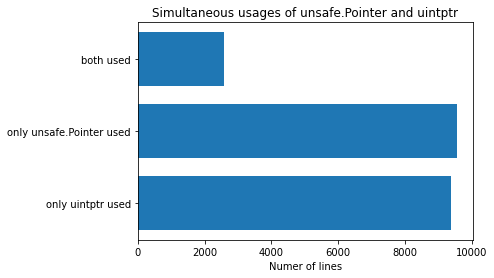

In [73]:
df1 = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer').dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

df2 = grep_df\
    .where(grep_df['match_type']=='uintptr').dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

mdf = pd.merge(df1, df2, how='outer', on=['package_import_path', 'file_name', 'line_number'])\
    .loc[:,['package_import_path', 'file_name', 'line_number', 'text_x', 'context_x', 'text_y', 'context_y', 
            'match_type_x', 'match_type_y']]

simultaneous_usages_df = mdf.dropna()
uintptr_without_unsafePointer_df = mdf.loc[mdf['match_type_x'].isnull()]
unsafePointer_without_uintptr_df = mdf.loc[mdf['match_type_y'].isnull()]

data = [uintptr_without_unsafePointer_df['line_number'].count(),
        unsafePointer_without_uintptr_df['line_number'].count(),
        simultaneous_usages_df['line_number'].count()]
idx = np.arange(3)/3
width = 0.25

plt.barh(idx, data, width)
plt.xlabel('Numer of lines')
plt.yticks(idx, ['only uintptr used', 'only unsafe.Pointer used', 'both used'])
plt.title('Simultaneous usages of unsafe.Pointer and uintptr')

tikzplotlib.save('/root/data/figures/correlation-together/use-in-same-line.tikz')

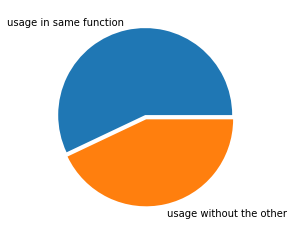

In [88]:
simultaneous_function_df = function_df\
    .where(function_df['number_unsafe_pointer'] > 0)\
    .where(function_df['number_uintptr'] > 0)\
    .dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

simultaneous_function_df['count'] = simultaneous_function_df.apply(
    lambda x: x['number_unsafe_pointer'] + x['number_uintptr'], axis=1)

simultaneousCount = simultaneous_function_df['count'].sum()

totalCount = ast_df\
    .where((ast_df['match_type']=='unsafe.Pointer')|(ast_df['match_type']=='uintptr'))\
    .dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])\
    ['line_number'].count()

data = [simultaneousCount, totalCount - simultaneousCount]

plt.pie(data, labels=['usage in same function', 'usage without the other'], explode=(0, 0.05))

tikzplotlib.save('/root/data/figures/correlation-together/use-in-same-function.tikz')

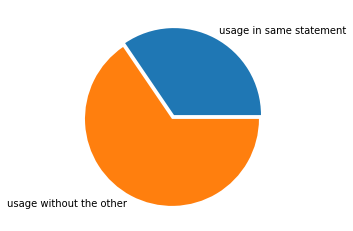

In [89]:
simultaneous_statement_df = statement_df\
    .where(statement_df['number_unsafe_pointer'] > 0)\
    .where(statement_df['number_uintptr'] > 0)\
    .dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

simultaneous_statement_df['count'] = simultaneous_statement_df.apply(
    lambda x: x['number_unsafe_pointer'] + x['number_uintptr'], axis=1)

total_statement_df = statement_df\
    .dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])
total_statement_df['count'] = total_statement_df.apply(
    lambda x: x['number_unsafe_pointer'] + x['number_uintptr'], axis=1)

totalCount = total_statement_df['count'].sum()
simultaneousCount = simultaneous_statement_df['count'].sum()

data = [simultaneousCount, totalCount - simultaneousCount]

plt.pie(data, labels=['usage in same statement', 'usage without the other'], explode=(0, 0.05))

tikzplotlib.save('/root/data/figures/correlation-together/use-in-same-statement.tikz')

# Section 6.5.6 Go Vet and Gosec tools coverage of unsafe snippets

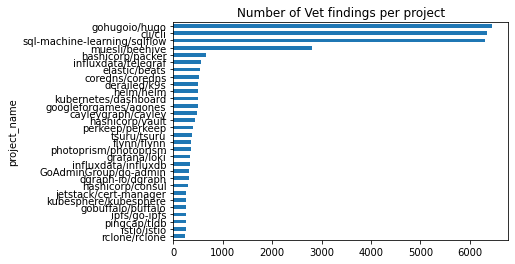

In [56]:
vet_df\
    .groupby('project_name')['project_name'].count()\
    .sort_values(ascending=True)[-30:]\
    .plot.barh(title='Number of Vet findings per project')

tikzplotlib.save('/root/data/figures/vet-gosec/vet-findings-per-project-n30.tikz')

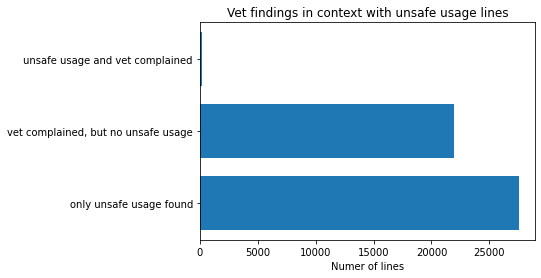

In [92]:
df1 = grep_df\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

df2 = vet_df\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

mdf = pd.merge(df1, df2, how='outer', on=['package_import_path', 'file_name', 'line_number'])\
    .loc[:,['package_import_path', 'file_name', 'line_number', 'text', 'context_x', 'match_type', 'message']]

vet_and_unsafe_df = mdf.dropna()
only_vet_df = mdf.loc[mdf['text'].isnull()]
only_unsafe_df = mdf.loc[mdf['message'].isnull()]

data = [only_unsafe_df['line_number'].count(),
        only_vet_df['line_number'].count(),
        vet_and_unsafe_df['line_number'].count()]
idx = np.arange(3)/3
width = 0.25

plt.barh(idx, data, width)
plt.xlabel('Numer of lines')
plt.yticks(idx, ['only unsafe usage found', 'vet complained, but no unsafe usage', 'unsafe usage and vet complained'])
plt.title('Vet findings in context with unsafe usage lines')

tikzplotlib.save('/root/data/figures/vet-gosec/vet-findings-correlated-unsafe-findings.tikz')

In [67]:
df = vet_df\
    .where(vet_df['message']=='possible misuse of unsafe.Pointer')\
    .dropna()\
    .groupby('package_import_path')['line_number'].count()\
    .sort_values(ascending=False)

print(df.to_latex(header=['unsafe.Pointer Vet findings'], index=True))

\begin{tabular}{lr}
\toprule
{} & unsafe.Pointer Vet finding \\
package\_import\_path                     &                            \\
\midrule
runtime                                 &                      60164 \\
sync/atomic                             &                        338 \\
strings                                 &                        335 \\
github.com/modern-go/reflect2           &                         46 \\
golang.org/x/sys/unix                   &                         16 \\
github.com/spaolacci/murmur3            &                         11 \\
gorgonia.org/tensor                     &                          8 \\
github.com/apache/arrow/go/arrow/math   &                          6 \\
github.com/minio/simdjson-go            &                          4 \\
github.com/apache/arrow/go/arrow/memory &                          4 \\
github.com/AndreasBriese/bbloom         &                          4 \\
github.com/coocood/bbloom               &                    

In [69]:
df = vet_df\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])\
    .where(vet_df['message']=='possible misuse of unsafe.Pointer')\
    .dropna()\
    .groupby('package_import_path')['line_number'].count()\
    .sort_values(ascending=False)

print(df.to_latex(header=['unsafe.Pointer Vet findings'], index=True))

\begin{tabular}{lr}
\toprule
{} & unsafe.Pointer Vet findings \\
package\_import\_path                     &                             \\
\midrule
runtime                                 &                         175 \\
gorgonia.org/tensor                     &                           8 \\
github.com/apache/arrow/go/arrow/math   &                           6 \\
github.com/minio/simdjson-go            &                           3 \\
github.com/apache/arrow/go/arrow/memory &                           3 \\
github.com/spaolacci/murmur3            &                           2 \\
github.com/coocood/bbloom               &                           2 \\
github.com/AndreasBriese/bbloom         &                           2 \\
sync/atomic                             &                           1 \\
strings                                 &                           1 \\
golang.org/x/sys/unix                   &                           1 \\
github.com/segmentio/encoding/json      &       

# Section 6.5.7 Correlation of unsafe usages with project features

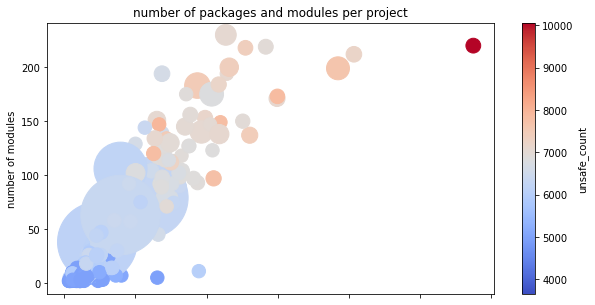

In [72]:
df1 = package_df\
    .groupby('project_name')['import_path'].nunique()

df2 = package_df\
    .groupby('project_name')['module_path'].nunique()

df3 = grep_df\
    .groupby('project_name')\
    .agg(unsafe_count=pd.NamedAgg(column='project_name', aggfunc='count'))

df4 = vet_df\
    .groupby('project_name')\
    .agg(vet_count=pd.NamedAgg(column='project_name', aggfunc='count'))

mdf1 = pd.merge(df1, df2, how='inner', on='project_name')
mdf2 = pd.merge(mdf1, df3, how='left', on='project_name')
mdf3 = pd.merge(mdf2, df4, how='left', on='project_name').fillna(0)

mdf3\
    .plot.scatter(x='import_path', y='module_path', c='unsafe_count', cmap="coolwarm", s=mdf3['vet_count'],
                  title='number of packages and modules per project',
                  figsize=(10,5))

plt.xlabel('number of packages')
plt.ylabel('number of modules')

tikzplotlib.save('/root/data/figures/correlation-project/correlation-imports-grep-vet.tikz')

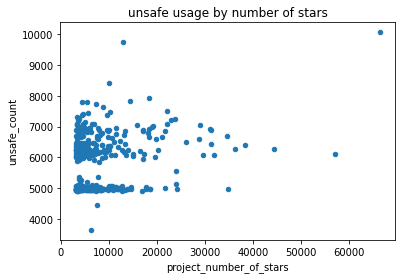

In [75]:
df1 = grep_df\
    .groupby('project_name')\
    .agg(unsafe_count=pd.NamedAgg(column='project_name', aggfunc='count'))

df2 = projects_df

unsafe_by_project_features_df = pd.merge(df1, df2, how='left', on=['project_name'])

unsafe_by_project_features_df\
    .plot.scatter(x='project_number_of_stars', y='unsafe_count',
                  title='unsafe usage by number of stars')

tikzplotlib.save('/root/data/figures/correlation-project/correlation-unsafe-stars.tikz')

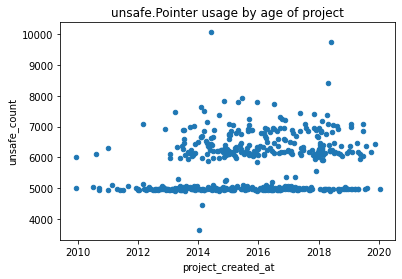

In [76]:
df1 = grep_df\
    .groupby('project_name')\
    .agg(unsafe_count=pd.NamedAgg(column='project_name', aggfunc='count'))

df2 = projects_df

unsafe_by_project_features_df = pd.merge(df1, df2, how='left', on=['project_name'])

unsafe_by_project_features_df\
    .plot.scatter(x='project_created_at', y='unsafe_count',
                  title='unsafe.Pointer usage by age of project')

tikzplotlib.save('/root/data/figures/correlation-project/correlation-unsafe-age.tikz')

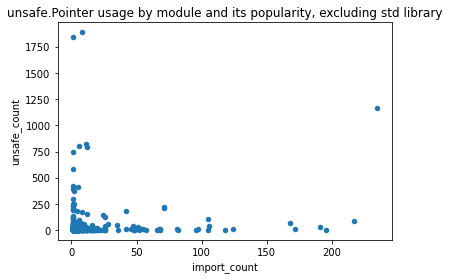

In [77]:
df1 = grep_df\
    .where(grep_df['module_path']!='std')\
    .groupby(['module_path', 'project_name'])\
    .agg(unsafe_count=pd.NamedAgg(column='module_path', aggfunc='count'))\
    .groupby('module_path').max()

df2 = package_df\
    .groupby('module_path')\
    .agg(import_count=pd.NamedAgg(column='project_name', aggfunc='nunique'))

df = pd.merge(df1, df2, how='left', on=['module_path'])

df.plot.scatter(x='import_count', y='unsafe_count', 
                title='unsafe.Pointer usage by module and its popularity, excluding std library')

tikzplotlib.save('/root/data/figures/correlation-project/correlation-unsafe-module-popularity.tikz')

# Section 6.5.8 Most interesting modules for analysis

In [85]:
df1 = grep_df\
    .groupby(['module_path', 'project_name'])\
    .agg(unsafe_count=pd.NamedAgg(column='module_path', aggfunc='count'))\
    .groupby('module_path').max()\
    .reset_index()

df2 = package_df\
    .groupby('module_path')\
    .agg(import_count=pd.NamedAgg(column='project_name', aggfunc='nunique'))\
    .reset_index()

unsafe_modules_weighted_popularity_df = pd.merge(df1, df2, how='inner', on=['module_path'])

weighted_df = unsafe_modules_weighted_popularity_df.reset_index()

weighted_df['score'] = weighted_df[['unsafe_count', 'import_count']]\
    .apply(lambda x: x['unsafe_count'] * x['import_count'], axis=1)

df = weighted_df\
    .sort_values(by='score', ascending=False)[:20].reset_index()

df.index = df.index + 1

df = df.loc[:,['module_path','unsafe_count','import_count','score']]

print(df.to_latex(header=['Module', 'Unsafe usages count', 'Import count', 'Score'], index=True))

\begin{tabular}{llrrr}
\toprule
{} &                           Module & Unsafe usages count & Import count &    Score \\
\midrule
1  &                              std &                6676 &          495 &  3304620 \\
2  &                 golang.org/x/sys &                1163 &          235 &   273305 \\
3  &                 golang.org/x/net &                  91 &          217 &    19747 \\
4  &      github.com/json-iterator/go &                 225 &           71 &    15975 \\
5  &    github.com/modern-go/reflect2 &                 215 &           71 &    15265 \\
6  &                k8s.io/kubernetes &                1887 &            8 &    15096 \\
7  &       github.com/golang/protobuf &                  65 &          168 &    10920 \\
8  &         github.com/gogo/protobuf &                 103 &          105 &    10815 \\
9  &  github.com/hashicorp/go-msgpack &                 792 &           12 &     9504 \\
10 &       github.com/ugorji/go/codec &                 823 &        